In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV

In [ ]:
# create scorer function
balanced_accuracy = make_scorer(balanced_accuracy_score)

In [ ]:
train_x_original = pd.read_csv("./artificial_train.data", sep=' ', header=None).iloc[:, :-1]
train_y_original = np.ravel(pd.read_csv("./artificial_train.labels", sep=' ', header=None))
test_x_original = pd.read_csv("./artificial_test.data", sep=' ', header=None).iloc[:, :-1]

In [ ]:
from sklearn.model_selection import train_test_split
train_x_auto, test_x_auto, train_y_auto, test_y_auto = train_test_split(train_x_original, train_y_original, test_size=0.25, random_state=11)

In [ ]:
train_x = train_x_auto.copy()

In [ ]:
test_x = test_x_original

In [ ]:
train_y = train_y_auto.copy()

In [ ]:
test_x.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
41,480,497,506,482,490,490,504,479,488,487,...,490,479,494,601,467,491,472,476,532,469
1457,479,439,520,482,489,489,546,476,463,477,...,493,479,492,495,435,512,476,480,516,509
1373,475,515,528,488,511,475,492,477,478,475,...,454,479,506,468,477,494,484,450,453,476
771,482,494,514,483,472,472,442,477,491,478,...,511,480,477,430,474,490,482,481,520,504
782,479,480,438,479,504,483,508,476,515,484,...,497,476,487,473,468,512,478,490,471,509


# Prepare dataset

In [ ]:
# Check for missing values
train_x.isna().sum().sum()

0

## Low variance

In [ ]:
var = train_x.var()
low_var = []
for i in range(0, len(var)):
    if var[i]==0:
        train_x.drop(i, axis=1, inplace=True)

In [ ]:
var_auto = train_x_auto.var()
low_var = []
for i in range(0, len(var_auto)):
    if var_auto[i]==0:
        train_x_auto.drop(i, axis=1, inplace=True)

In [ ]:
train_x_auto

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
1915,478,474,476,486,478,478,489,477,485,478,...,478,475,476,470,519,544,484,470,443,489
61,472,546,542,479,569,479,459,476,493,467,...,476,480,476,618,501,582,487,487,479,488
1006,500,450,483,466,537,479,504,477,461,488,...,441,481,500,477,512,538,478,477,508,535
1264,472,482,510,483,541,476,452,478,476,477,...,492,479,495,574,536,448,474,489,479,489
382,483,436,509,490,455,479,501,477,522,474,...,444,485,475,285,510,497,477,463,511,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1361,487,520,545,487,535,476,540,476,485,477,...,484,475,459,302,469,524,473,480,459,525
1115,489,520,462,487,497,477,523,475,479,484,...,496,481,467,674,464,547,472,469,508,532
1104,484,470,490,475,506,489,492,475,494,485,...,512,482,480,544,542,496,473,458,437,468
1727,480,485,468,490,457,488,526,475,476,474,...,489,480,444,403,526,564,481,495,461,519


## High correlation

In [ ]:
# Remove columns with high correlation > 0.9
corr_matrix = train_x.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features
train_x.drop(to_drop, axis=1, inplace=True)
test_x.drop(to_drop, axis=1, inplace=True)

In [ ]:
train_x

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,494,495,496,497,498,499
1915,478,474,476,486,478,478,489,477,485,478,...,477,478,475,476,519,544,484,470,443,489
61,472,546,542,479,569,479,459,476,493,467,...,481,476,480,476,501,582,487,487,479,488
1006,500,450,483,466,537,479,504,477,461,488,...,482,441,481,500,512,538,478,477,508,535
1264,472,482,510,483,541,476,452,478,476,477,...,482,492,479,495,536,448,474,489,479,489
382,483,436,509,490,455,479,501,477,522,474,...,460,444,485,475,510,497,477,463,511,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1361,487,520,545,487,535,476,540,476,485,477,...,468,484,475,459,469,524,473,480,459,525
1115,489,520,462,487,497,477,523,475,479,484,...,482,496,481,467,464,547,472,469,508,532
1104,484,470,490,475,506,489,492,475,494,485,...,486,512,482,480,542,496,473,458,437,468
1727,480,485,468,490,457,488,526,475,476,474,...,482,489,480,444,526,564,481,495,461,519


In [ ]:
test_x

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,494,495,496,497,498,499
0,483,454,513,495,523,469,453,477,506,479,...,464,455,480,543,413,520,485,498,523,510
1,485,508,493,487,478,472,504,476,479,475,...,468,486,480,535,514,452,484,495,548,477
2,483,521,507,475,493,486,421,475,496,483,...,477,491,476,498,508,528,486,465,508,503
3,474,504,576,480,553,483,524,478,483,483,...,481,521,475,470,509,525,479,467,552,517
4,495,474,523,479,495,488,485,476,497,478,...,464,510,471,522,509,520,475,493,506,491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,493,458,503,478,517,479,472,478,444,477,...,475,469,475,485,517,486,474,489,506,506
596,481,484,481,490,449,481,467,478,469,483,...,468,506,485,508,498,527,481,490,455,451
597,485,485,530,480,444,487,462,475,509,494,...,477,442,474,502,453,482,478,481,484,517
598,477,469,528,485,483,469,482,477,494,476,...,470,473,476,453,471,538,470,490,613,492


## Feature importance (random forest)

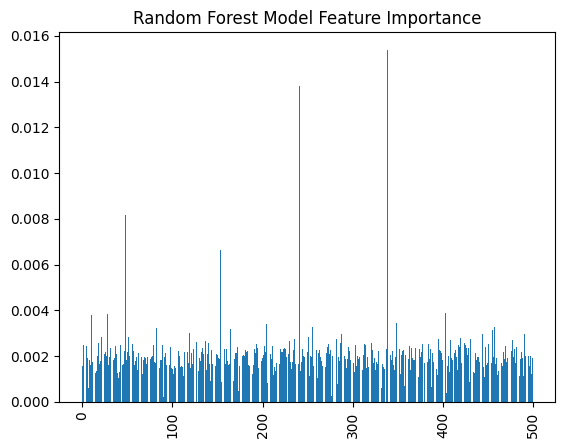

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


model = RandomForestClassifier(n_estimators = 100, random_state=42)
model.fit(train_x, train_y)
feature_df = pd.DataFrame({"Importance":model.feature_importances_, "Features": train_x.columns })

plt.bar(feature_df["Features"], feature_df["Importance"])
plt.xticks(rotation=90)
plt.title("Random Forest Model Feature Importance")
plt.show()

In [ ]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state=42))
sel.fit(train_x, train_y)
sel.get_support().sum()

197

In [ ]:
test_x

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,494,495,496,497,498,499
0,483,454,513,495,523,469,453,477,506,479,...,464,455,480,543,413,520,485,498,523,510
1,485,508,493,487,478,472,504,476,479,475,...,468,486,480,535,514,452,484,495,548,477
2,483,521,507,475,493,486,421,475,496,483,...,477,491,476,498,508,528,486,465,508,503
3,474,504,576,480,553,483,524,478,483,483,...,481,521,475,470,509,525,479,467,552,517
4,495,474,523,479,495,488,485,476,497,478,...,464,510,471,522,509,520,475,493,506,491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,493,458,503,478,517,479,472,478,444,477,...,475,469,475,485,517,486,474,489,506,506
596,481,484,481,490,449,481,467,478,469,483,...,468,506,485,508,498,527,481,490,455,451
597,485,485,530,480,444,487,462,475,509,494,...,477,442,474,502,453,482,478,481,484,517
598,477,469,528,485,483,469,482,477,494,476,...,470,473,476,453,471,538,470,490,613,492


In [ ]:
# Remove unimportant features

train_x_rf = train_x.loc[:, sel.get_support()]
test_x_rf = test_x.loc[:, sel.get_support()]

In [ ]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state=42))
sel.fit(train_x_rf, train_y)
sel.get_support().sum()

49

In [ ]:
# Remove unimportant features

train_x_rf = train_x_rf.loc[:, sel.get_support()]
test_x_rf = test_x_rf.loc[:, sel.get_support()]

In [ ]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state=42))
sel.fit(train_x_rf, train_y)
sel.get_support().sum()

10

In [ ]:
# Remove unimportant features

train_x_rf = train_x_rf.loc[:, sel.get_support()]
test_x_rf = test_x_rf.loc[:, sel.get_support()]

In [ ]:
train_x_rf

,10,28,48,64,105,153,241,338,442,453
1915,498,481,396,502,375,539,495,498,490,462
61,481,483,507,387,749,587,548,328,441,584
1006,448,509,474,607,475,663,476,401,262,466
1264,477,494,462,534,501,525,455,508,499,540
382,509,458,513,567,289,335,509,701,593,277
...,...,...,...,...,...,...,...,...,...,...
1361,455,474,484,469,416,531,590,420,349,250
1115,529,495,461,455,691,586,472,401,491,657
1104,514,488,518,483,602,472,487,490,506,524
1727,481,484,453,485,423,446,516,538,481,389


# Manual models

## Random Forest

### Prepare grid

In [ ]:
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 25, num = 5)]
max_depth.append(None)

# Create the random forest grid
random_grid = {'model__n_estimators': [int(x) for x in np.linspace(start = 50, stop = 200, num = 7)],
               'model__max_features': ['log2', 'sqrt', None],
               'model__max_depth': max_depth,
               'model__min_samples_split': [2, 5, 10],
               'model__min_samples_leaf': [1, 2, 4],
               'model__bootstrap': [True, False]}

### Without preprocessing

In [ ]:
rf_model = RandomizedSearchCV(
    estimator = Pipeline([
            ('scaler', StandardScaler()),
            ('model', RandomForestClassifier()),
        ]),
    param_distributions = random_grid,
    scoring = balanced_accuracy,
    n_iter = 5,
    cv = 5,
    verbose=1,
    random_state=42,
    n_jobs = -1
)

In [ ]:
rf_model.fit(train_x, train_y)

In [ ]:
rf_model.best_score_

In [ ]:
default_best_model = rf_model.best_estimator_
default_best_params = rf_model.best_params_

In [ ]:
pred_train = default_best_model.predict(train_x)

In [ ]:
# balanced accuracy on train set
print(f" balanced accuracy {balanced_accuracy_score(train_y, pred_train)}")

### Feature importance

In [ ]:
rf_model = RandomizedSearchCV(
    estimator = Pipeline([
            ('scaler', StandardScaler()),
            ('model', RandomForestClassifier()),
        ]),
    param_distributions = random_grid,
    scoring = balanced_accuracy,
    n_iter = 50,
    cv = 5,
    verbose=1,
    random_state=42,
    n_jobs = -1
)

In [ ]:
rf_model.fit(train_x_rf, train_y)

In [ ]:
rf_model.best_score_

In [ ]:
rf_best_model = rf_model.best_estimator_
rf_best_params = rf_model.best_params_

In [ ]:
pred_train = rf_best_model.predict(train_x_rf)

In [ ]:
# balanced accuracy on train set
print(f" balanced accuracy {balanced_accuracy_score(train_y, pred_train)}")

## XGBoost

### Prepare grid

In [ ]:
# XGB grid
xgb_grid = {
    'model__gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,5],
    'model__learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3],
    'model__max_depth': [3,5,6,7,8,9,10],
    'model__n_estimators': [50,75,100,125,150,175,200],
    'model__reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
    'model__reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]
}

### Without preprocessing

In [ ]:
print(train_y)
xgb_model = RandomizedSearchCV(
    estimator = Pipeline([
            ('scaler', StandardScaler()),
            ('model', xgb.XGBClassifier()),
        ]),
    param_distributions = xgb_grid,
    n_iter = 5,
    scoring=balanced_accuracy,
    cv = 5,
    verbose=1,
    random_state=42,
    n_jobs = -1
)

[-1 -1 -1 ... -1  1  1]


In [ ]:
xgb_model.fit(train_x, train_y)

In [ ]:
xgb_model.best_score_

0.79

In [ ]:
xgb_default_best_model = xgb_model.best_estimator_
xgb_default_best_params = xgb_model.best_params_

In [ ]:
pred_train = xgb_default_best_model.predict(train_x)

In [ ]:
# balanced accuracy on train set
print(f" balanced accuracy {balanced_accuracy_score(train_y, pred_train)}")

 balanced accuracy 1.0


### Feature importance

In [ ]:
xgb_model = RandomizedSearchCV(
    estimator = Pipeline([
            ('scaler', StandardScaler()),
            ('model', xgb.XGBClassifier()),
        ]),
    param_distributions = xgb_grid,
    n_iter = 50,
    scoring=balanced_accuracy,
    cv = 5,
    verbose=1,
    random_state=42,
    n_jobs = -1
)

In [ ]:
xgb_model.fit(train_x_rf, train_y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model', XGBClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'model__gamma': [0, 0.1, 0.2, 0.4, 0.8,
                                                         1.6, 3.2, 5],
                                        'model__learning_rate': [0.01, 0.03,
                                                                 0.06, 0.1,
                                                                 0.15, 0.2,
                                                                 0.25, 0.3],
                                        'model__max_depth': [3, 5, 6, 7, 8, 9,
                                                             10],
                                        'model__n_estimators': [50, 75, 100,
                                                                125, 150, 175,
                                                                200],
                                        'model__reg_alpha': [0, 0.1, 0.2, 0.4,
                                                             0.8, 1.6, 3.2, 6.4,
                                                             12.8, 25.6, 51.2,
                                                             102.4, 200],
                                        'model__reg_lambda': [0, 0.1, 0.2, 0.4,
                                                              0.8, 1.6, 3.2,
                                                              6.4, 12.8, 25.6,
                                                              51.2, 102.4,
                                                              200]},
                   random_state=42,
                   scoring=make_scorer(balanced_accuracy_score), verbose=1)

In [ ]:
xgb_model.best_score_

0.875

In [ ]:
xgb_rf_best_model = xgb_model.best_estimator_
xgb_rf_best_params = xgb_model.best_params_

In [ ]:
pred_train = xgb_rf_best_model.predict(train_x_rf)

In [ ]:
# balanced accuracy on train set
print(f" balanced accuracy {balanced_accuracy_score(train_y, pred_train)}")

 balanced accuracy 0.9924999999999999


### Save the best model

In [ ]:
rf_best_params

{'model__n_estimators': 75,
 'model__min_samples_split': 10,
 'model__min_samples_leaf': 2,
 'model__max_features': 'log2',
 'model__max_depth': 25,
 'model__bootstrap': False}

In [ ]:
best_model = rf_best_model
best_pred = best_model.predict_proba(test_x_rf)[:,1]

In [ ]:
with open("313293_317253_artifical_model_prediction.txt", "w") as file:
    for p in best_pred:
        file.write(str(p) + "\n")

# AutoML models

##AutoSklearn


###Prepare models


In [ ]:
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.experimental.askl2 import AutoSklearn2Classifier
from autosklearn.metrics import roc_auc,balanced_accuracy

settings = {
  "time_left_for_this_task": 600,  # seconds
  "seed": 42,
  "metric": balanced_accuracy,
  "n_jobs": 4,
}
resampling_strategy = "holdout"
askl1 = AutoSklearnClassifier(
    **settings,
    resampling_strategy=resampling_strategy
)
askl1_preprocessing = AutoSklearnClassifier(
    **settings,
    resampling_strategy=resampling_strategy
)



###Without preprocessing

In [ ]:
train_x_auto

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,494,495,496,497,498,499
1915,478,474,476,486,478,478,489,477,485,478,...,477,478,475,476,519,544,484,470,443,489
61,472,546,542,479,569,479,459,476,493,467,...,481,476,480,476,501,582,487,487,479,488
1006,500,450,483,466,537,479,504,477,461,488,...,482,441,481,500,512,538,478,477,508,535
1264,472,482,510,483,541,476,452,478,476,477,...,482,492,479,495,536,448,474,489,479,489
382,483,436,509,490,455,479,501,477,522,474,...,460,444,485,475,510,497,477,463,511,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1361,487,520,545,487,535,476,540,476,485,477,...,468,484,475,459,469,524,473,480,459,525
1115,489,520,462,487,497,477,523,475,479,484,...,482,496,481,467,464,547,472,469,508,532
1104,484,470,490,475,506,489,492,475,494,485,...,486,512,482,480,542,496,473,458,437,468
1727,480,485,468,490,457,488,526,475,476,474,...,482,489,480,444,526,564,481,495,461,519


In [ ]:
train_y_auto

array([-1,  1, -1, ..., -1, -1,  1])

In [ ]:
askl1.fit(train_x_auto, train_y_auto)

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      metric=balanced_accuracy, n_jobs=4,
                      per_run_time_limit=240, seed=42,
                      time_left_for_this_task=600)

In [ ]:
from pprint import pprint
print(f"Selected `resampling-strategy` = {askl1.resampling_strategy}")
print(f"Selected `resampling-strategy-arguments` = {askl1.resampling_strategy_arguments}")

print(askl1.sprint_statistics())
leaderboard = askl1.leaderboard(sort_by="model_id", ensemble_only=True)
print(leaderboard)
pprint(askl1.show_models())


Selected `resampling-strategy` = holdout
Selected `resampling-strategy-arguments` = None
auto-sklearn results:
  Dataset name: 2e54a28e-b492-11ee-9eed-0242ac1c000c
  Metric: balanced_accuracy
  Best validation score: 0.854565
  Number of target algorithm runs: 55
  Number of successful target algorithm runs: 45
  Number of crashed target algorithm runs: 1
  Number of target algorithms that exceeded the time limit: 4
  Number of target algorithms that exceeded the memory limit: 5

          rank  ensemble_weight               type      cost   duration
model_id                                                               
2            9             0.04      random_forest  0.331105  32.896234
7            8             0.02      random_forest  0.302895  27.439093
8            1             0.18      random_forest  0.145435  47.678702
9            2             0.04        extra_trees  0.159614  41.225403
20          11             0.06           adaboost  0.375894  94.550661
24         

Calculate Balanced Accuracy Score

In [ ]:
test_y_pred = askl1.predict(test_x_auto)
balancedAccuracyScore = balanced_accuracy_score(test_y_auto, test_y_pred)
print(f"Balanced accuracy score fo AutoSklearn = {balancedAccuracyScore}")

Balanced accuracy score fo AutoSklearn = 0.8474589835934374


###Feature importance

In [ ]:
train_x_rf.columns = range(len(train_x_rf.columns))
test_x_rf.columns = range(len(test_x_rf.columns))

In [ ]:
test_x_rf

,0,1,2,3,4,5,6,7,8,9
41,564,473,519,389,686,551,552,399,493,592
1457,451,466,460,592,298,514,456,569,555,481
1373,458,491,441,589,367,489,425,588,496,456
771,520,466,504,573,377,462,492,613,539,432
782,499,503,434,367,612,445,527,441,471,460
...,...,...,...,...,...,...,...,...,...,...
713,544,460,510,508,569,591,466,493,651,754
1924,475,495,541,480,685,259,420,632,638,531
1596,443,501,465,460,637,458,462,488,505,536
1385,475,464,540,394,700,590,531,389,533,646


In [ ]:
train_x_rf

,0,1,2,3,4,5,6,7,8,9
1915,498,481,396,502,375,539,495,498,490,462
61,481,483,507,387,749,587,548,328,441,584
1006,448,509,474,607,475,663,476,401,262,466
1264,477,494,462,534,501,525,455,508,499,540
382,509,458,513,567,289,335,509,701,593,277
...,...,...,...,...,...,...,...,...,...,...
1361,455,474,484,469,416,531,590,420,349,250
1115,529,495,461,455,691,586,472,401,491,657
1104,514,488,518,483,602,472,487,490,506,524
1727,481,484,453,485,423,446,516,538,481,389


In [ ]:
askl1_preprocessing.fit(train_x_rf, train_y_auto)

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      metric=balanced_accuracy, n_jobs=4,
                      per_run_time_limit=240, seed=42,
                      time_left_for_this_task=600)

Results summary

In [ ]:
from pprint import pprint
print(f"Selected `resampling-strategy` = {askl1_preprocessing.resampling_strategy}")
print(f"Selected `resampling-strategy-arguments` = {askl1_preprocessing.resampling_strategy_arguments}")

print(askl1_preprocessing.sprint_statistics())
leaderboard = askl1_preprocessing.leaderboard(sort_by="model_id", ensemble_only=True)
print(leaderboard)
askl1_preprocessing.automl_.runhistory_.data
# Show all the models in the final produced ensemble
#pprint(askl1_preprocessing.show_models())

Selected `resampling-strategy` = holdout
Selected `resampling-strategy-arguments` = None
auto-sklearn results:
  Dataset name: 512b1120-b49a-11ee-9eed-0242ac1c000c
  Metric: balanced_accuracy
  Best validation score: 0.860540
  Number of target algorithm runs: 71
  Number of successful target algorithm runs: 68
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 3
  Number of target algorithms that exceeded the memory limit: 0

          rank  ensemble_weight                 type      cost   duration
model_id                                                                 
2            2             0.04        random_forest  0.161598   7.760193
4            6             0.12          extra_trees  0.167818   6.850340
9           13             0.20             adaboost  0.268636  10.300862
10           8             0.02    gradient_boosting  0.183759  32.879976
21          11             0.06             adaboost  0.252743  17.0548

OrderedDict([(RunKey(config_id=1, instance_id='{"task_id": "512b1120-b49a-11ee-9eed-0242ac1c000c"}', seed=0, budget=0.0),
              RunValue(cost=0.16159760995200312, time=7.760193347930908, status=<StatusType.SUCCESS: 1>, starttime=1705428540.0699475, endtime=1705428547.9021509, additional_info={'duration': 7.4303975105285645, 'num_run': 2, 'train_loss': 0.0, 'configuration_origin': 'Initial design'})),
             (RunKey(config_id=2, instance_id='{"task_id": "512b1120-b49a-11ee-9eed-0242ac1c000c"}', seed=0, budget=0.0),
              RunValue(cost=0.3676657850915859, time=3.5592994689941406, status=<StatusType.SUCCESS: 1>, starttime=1705428540.0824006, endtime=1705428543.6721203, additional_info={'duration': 3.3394625186920166, 'num_run': 3, 'train_loss': 0.4088711018875696, 'configuration_origin': 'Initial design'})),
             (RunKey(config_id=3, instance_id='{"task_id": "512b1120-b49a-11ee-9eed-0242ac1c000c"}', seed=0, budget=0.0),
              RunValue(cost=0.167817611

Calculate Balanced Accuracy Score

In [ ]:
test_y_pred = askl1_preprocessing.predict(test_x_rf)
balancedAccuracyScore = balanced_accuracy_score(test_y_auto, test_y_pred)
print(f"Balanced accuracy score for AutoSklearn2 = {balancedAccuracyScore}")

Balanced accuracy score for AutoSklearn2 = 0.8678671468587436


##AutoSklearn2

###Prepare models

In [ ]:
# Create and train AutoSklearn2.0
import pandas as pd
pd.DataFrame.iteritems = pd.DataFrame.items

askl2 = AutoSklearn2Classifier(**settings)
askl2_preprocessing = AutoSklearn2Classifier(**settings)

###Without Preprocessing

Train

In [ ]:
askl2.fit(train_x_auto, train_y_auto)

AutoSklearn2Classifier(metric=balanced_accuracy, n_jobs=4,
                       per_run_time_limit=240, seed=42,
                       time_left_for_this_task=600)

Results summary

In [ ]:
print(f"Selected `resampling-strategy` = {askl2.resampling_strategy}")
print(f"Selected `resampling-strategy-arguments` = {askl2.resampling_strategy_arguments}")

print(askl2.sprint_statistics())
leaderboard = askl2.leaderboard(sort_by="model_id", ensemble_only=True)
print(leaderboard)
# askl1.automl_.runhistory_.data
# Show all the models in the final produced ensemble
pprint(askl2.show_models())

Selected `resampling-strategy` = cv-iterative-fit
Selected `resampling-strategy-arguments` = {'folds': 10}
auto-sklearn results:
  Dataset name: 079954ec-b494-11ee-9eed-0242ac1c000c
  Metric: balanced_accuracy
  Best validation score: 0.828312
  Number of target algorithm runs: 21
  Number of successful target algorithm runs: 19
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 2
  Number of target algorithms that exceeded the memory limit: 0

          rank  ensemble_weight           type      cost    duration
model_id                                                            
2            3             0.02    extra_trees  0.185156   96.299922
8            1             0.04    extra_trees  0.171688  103.829717
9            4             0.80            sgd  0.463392   37.510089
15           2             0.02  random_forest  0.178682  183.703285
17           5             0.12    extra_trees  0.486684   45.266646
{2: {'balancin

Calculate Balanced Accuracy Score

In [ ]:
test_y_pred = askl2.predict(test_x_auto)
balancedAccuracyScore = balanced_accuracy_score(test_y_auto, test_y_pred)
print(f"Balanced accuracy score for AutoSklearn2 = {balancedAccuracyScore}")

Balanced accuracy score for AutoSklearn2 = 0.8433773509403761


###Feature importance

Train

In [ ]:
askl2_preprocessing.fit(train_x_rf, train_y_auto)

AutoSklearn2Classifier(metric=balanced_accuracy, n_jobs=4,
                       per_run_time_limit=240, seed=42,
                       time_left_for_this_task=600)

Results summary

In [ ]:
print(f"Selected `resampling-strategy` = {askl2_preprocessing.resampling_strategy}")
print(f"Selected `resampling-strategy-arguments` = {askl2_preprocessing.resampling_strategy_arguments}")

print(askl2_preprocessing.sprint_statistics())
leaderboard = askl2_preprocessing.leaderboard(sort_by="model_id", ensemble_only=True)
print(leaderboard)
# askl1.automl_.runhistory_.data
# Show all the models in the final produced ensemble
pprint(askl2_preprocessing.show_models())

Selected `resampling-strategy` = cv-iterative-fit
Selected `resampling-strategy-arguments` = {'folds': 5}
auto-sklearn results:
  Dataset name: e766297d-b49b-11ee-9eed-0242ac1c000c
  Metric: balanced_accuracy
  Best validation score: 0.882097
  Number of target algorithm runs: 87
  Number of successful target algorithm runs: 85
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 2
  Number of target algorithms that exceeded the memory limit: 0

          rank  ensemble_weight           type      cost   duration
model_id                                                           
3            8             0.02    extra_trees  0.143264  17.971571
8           10             0.02            mlp  0.147802  53.489980
10           3             0.02    extra_trees  0.125948  52.983433
15          11             0.02  random_forest  0.181297  20.453343
16           9             0.02    extra_trees  0.143909  22.062224
27           1        

Calculate Balanced Accuracy Score

In [ ]:
test_y_pred = askl2_preprocessing.predict(test_x_rf)
balancedAccuracyScore = balanced_accuracy_score(test_y_auto, test_y_pred)
print(f"Balanced accuracy score for AutoSklearn2 = {balancedAccuracyScore}")

Balanced accuracy score for AutoSklearn2 = 0.8654261704681874


##Autogluon

###Prepare models

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor
agl = TabularPredictor(label='y', eval_metric='balanced_accuracy')
agl_preprocessing = TabularPredictor(label="y", eval_metric = 'balanced_accuracy')

No path specified. Models will be saved in: "AutogluonModels/ag-20240116_205749/"
No path specified. Models will be saved in: "AutogluonModels/ag-20240116_205749-001/"


###Without preprocessing

In [ ]:
train_x_auto

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
1915,478,474,476,486,478,478,489,477,485,478,...,478,475,476,470,519,544,484,470,443,489
61,472,546,542,479,569,479,459,476,493,467,...,476,480,476,618,501,582,487,487,479,488
1006,500,450,483,466,537,479,504,477,461,488,...,441,481,500,477,512,538,478,477,508,535
1264,472,482,510,483,541,476,452,478,476,477,...,492,479,495,574,536,448,474,489,479,489
382,483,436,509,490,455,479,501,477,522,474,...,444,485,475,285,510,497,477,463,511,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1361,487,520,545,487,535,476,540,476,485,477,...,484,475,459,302,469,524,473,480,459,525
1115,489,520,462,487,497,477,523,475,479,484,...,496,481,467,674,464,547,472,469,508,532
1104,484,470,490,475,506,489,492,475,494,485,...,512,482,480,544,542,496,473,458,437,468
1727,480,485,468,490,457,488,526,475,476,474,...,489,480,444,403,526,564,481,495,461,519


In [ ]:
train_y_df = pd.DataFrame(train_y_auto, columns=[0])
test_y_df = pd.DataFrame(test_y_auto,columns=[0])

In [ ]:
train_data = TabularDataset(np.concatenate([train_x_auto, train_y_df], axis=1))
train_data = train_data.rename(columns={len(train_x_auto.columns): 'y'})


test_data = TabularDataset(np.concatenate([test_x_auto, test_y_df], axis=1))
test_data = train_data.rename(columns={500: 'y'})
train_data

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,y
0,478,474,476,486,478,478,489,477,485,478,...,475,476,470,519,544,484,470,443,489,-1
1,472,546,542,479,569,479,459,476,493,467,...,480,476,618,501,582,487,487,479,488,1
2,500,450,483,466,537,479,504,477,461,488,...,481,500,477,512,538,478,477,508,535,-1
3,472,482,510,483,541,476,452,478,476,477,...,479,495,574,536,448,474,489,479,489,-1
4,483,436,509,490,455,479,501,477,522,474,...,485,475,285,510,497,477,463,511,500,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,487,520,545,487,535,476,540,476,485,477,...,475,459,302,469,524,473,480,459,525,1
1496,489,520,462,487,497,477,523,475,479,484,...,481,467,674,464,547,472,469,508,532,-1
1497,484,470,490,475,506,489,492,475,494,485,...,482,480,544,542,496,473,458,437,468,-1
1498,480,485,468,490,457,488,526,475,476,474,...,480,444,403,526,564,481,495,461,519,-1


Train

In [ ]:
agl.fit(train_data)

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/utils.py:556: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True): # treat None, NaN, INF, NINF as NA
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240116_200302/"
AutoGluon Version:  0.8.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
Disk Space Avail:   79.47 GB / 115.66 GB (68.7%)
Train Data Rows:    1500
Train Data Columns: 490
Label Column: y
Preprocessing data ...
/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/utils.py:556: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True): # tr

In [ ]:
test_y_pred = agl.predict(test_x_auto)
balancedAccuracyScore = balanced_accuracy_score(test_y_auto, test_y_pred)
print(f"Balanced accuracy score for AutoGluon = {balancedAccuracyScore}")

###Feature importance

In [ ]:
train_data_rf = TabularDataset(np.concatenate([train_x_rf, train_y_df], axis=1))
train_data_rf = train_data_rf.rename(columns={len(train_x_rf.columns): 'y'})

test_data_rf = TabularDataset(np.concatenate([test_x_rf, test_y_df], axis=1))
test_data_rf = train_data_rf.rename(columns={len(train_x_rf.columns): 'y'})

In [ ]:
agl_preprocessing.fit(train_data_rf)

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/utils.py:556: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True): # treat None, NaN, INF, NINF as NA
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240116_205749-001/"
AutoGluon Version:  0.8.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
Disk Space Avail:   79.43 GB / 115.66 GB (68.7%)
Train Data Rows:    1500
Train Data Columns: 10
Label Column: y
Preprocessing data ...
/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/utils.py:556: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True): #

Calculate Balanced Accuracy Score

In [ ]:
test_y_pred = agl_preprocessing.predict(test_x_rf)
balancedAccuracyScore = balanced_accuracy_score(test_y_auto, test_y_pred)
print(f"Balanced accuracy score for AutoGluon = {balancedAccuracyScore}")

Balanced accuracy score for AutoGluon = 0.8717887154861945


##Save the best model

In [ ]:
best_pred = agl_preprocessing.predict_proba(test_x_rf)[1]

In [ ]:
best_pred

0      0.113762
1      0.013197
2      0.735627
3      0.964727
4      0.138973
         ...   
595    0.962216
596    0.243321
597    0.993226
598    0.931023
599    0.025522
Name: 1, Length: 600, dtype: float64

In [ ]:
with open("313293_317253_artifical_automl_prediction.txt", "w") as file:
    for p in best_pred:
        file.write(str(p) + "\n")